/opt/anaconda3/lib/python3.8/site-packages/huggingface_hub/file_download.py:671: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


https://huggingface.co/eugenesiow/edsr-base/resolve/main/pytorch_model_2x.pt
PSNR: 35.57
SSIM: 0.9767
PSNR: 34.82
SSIM: 0.9878
PSNR: 26.11
SSIM: 0.9377
PSNR: 31.49
SSIM: 0.9219
PSNR: 30.79
SSIM: 0.9712


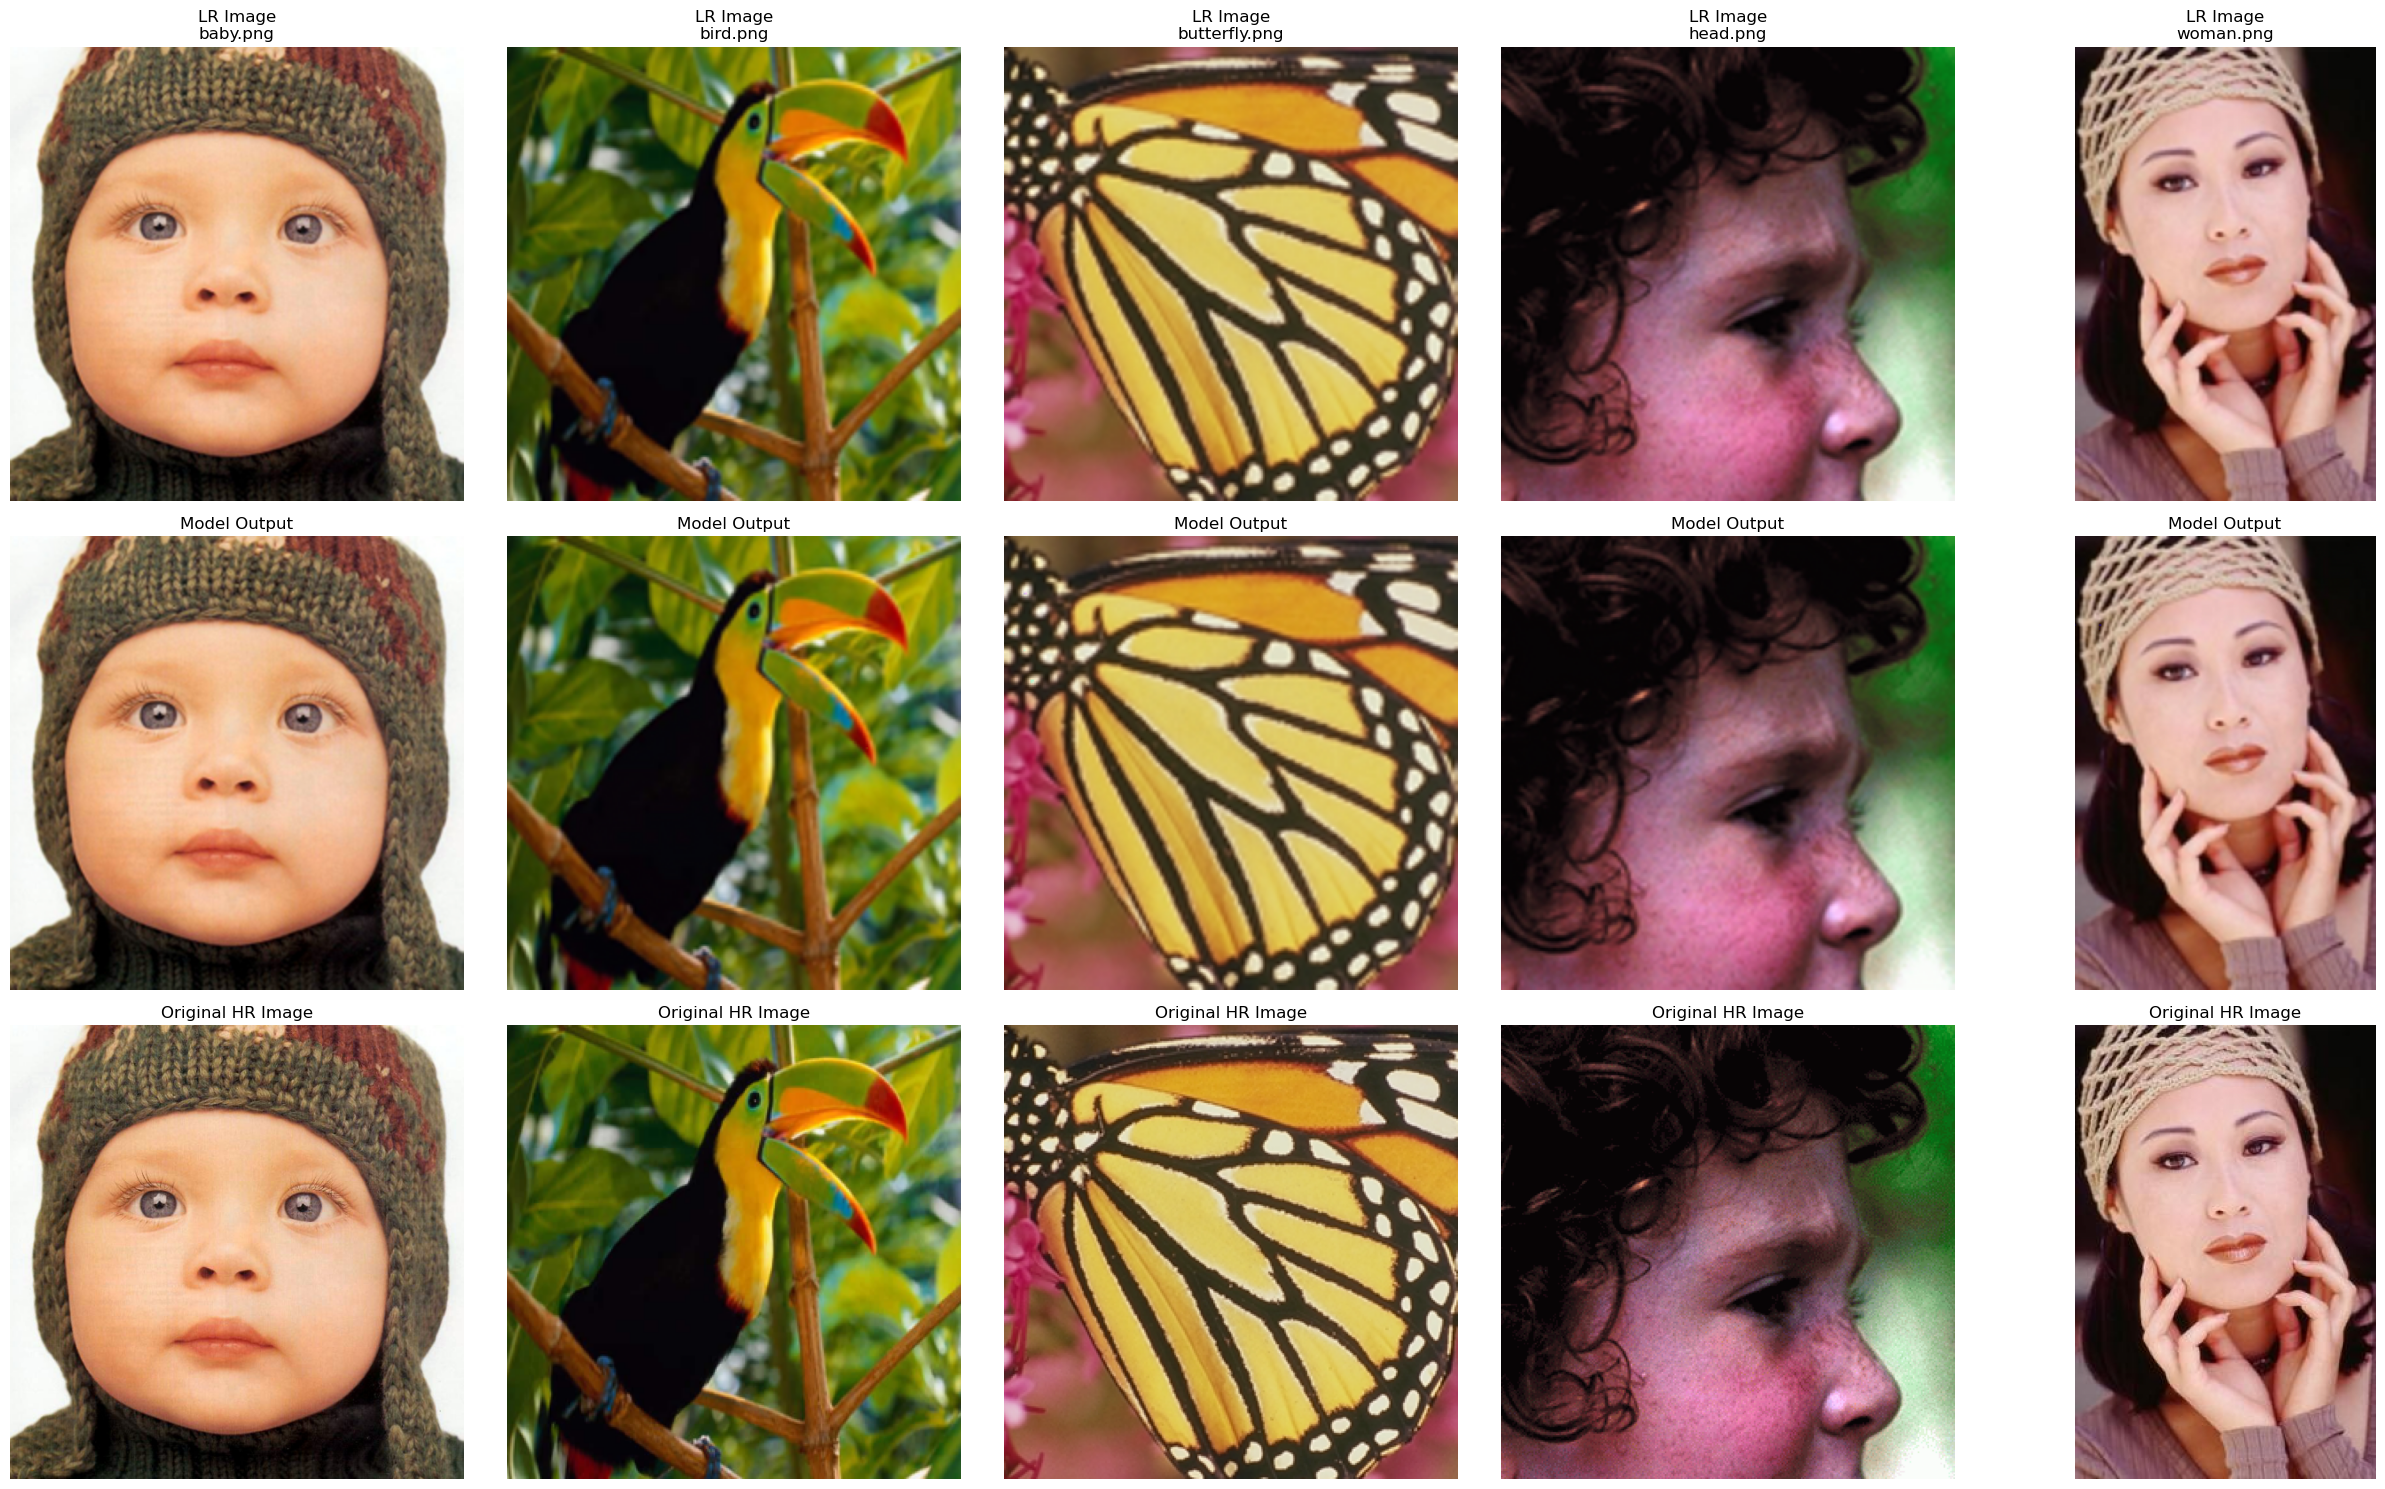

In [1]:
import os
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from super_image import EdsrModel
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np
from PIL import ImageOps
from skimage.metrics import structural_similarity as ssim

folder_path = '/Users/only/Downloads/set5'
model = EdsrModel.from_pretrained('eugenesiow/edsr-base', scale=2)
model.eval()
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()
fig, axes = plt.subplots(3, 5, figsize=(25, 15))
axes = axes.flatten()

def downsample_image(image):
    scale_factor = 2
    width, height = image.size
    downsized_image = image.resize((width // scale_factor, height // scale_factor), Image.BICUBIC)
    return downsized_image.resize((width, height), Image.BICUBIC)

for i, filename in enumerate(sorted(os.listdir(folder_path))):
    if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp')) and i < 5:
        image_path = os.path.join(folder_path, filename)
        hr_image = Image.open(image_path).convert('RGB')
        lr_image = downsample_image(hr_image)
        
        hr_tensor = to_tensor(hr_image)
        lr_tensor = to_tensor(lr_image)

        with torch.no_grad():
            sr_tensor = model(lr_tensor.unsqueeze(0)).squeeze(0)
            sr_image = to_pil(sr_tensor)
        sr_np = np.array(sr_image)
        hr_np = np.array(hr_image)
        
        sr_image = to_pil(sr_tensor)

        if sr_image.size != hr_image.size:
            sr_image = sr_image.resize(hr_image.size, Image.BICUBIC)
        sr_np = np.array(sr_image)
        hr_np = np.array(hr_image)
        
        try:
            image_psnr = psnr(hr_np, sr_np, data_range=255)
            print(f"PSNR: {image_psnr:.2f}")
        except ValueError as e:
            print(f"Error calculating PSNR: {e}")
        
        try:
            min_dimension = min(hr_np.shape[:2])
            image_ssim = ssim(hr_np, sr_np, multichannel=True, data_range=255, win_size=3)
            print(f"SSIM: {image_ssim:.4f}")
        except ValueError as e:
            print(f"Error calculating SSIM with win_size {win_size}: {e}")
        axes[i].imshow(lr_image)
        axes[i + 5].imshow(sr_image)
        axes[i + 10].imshow(hr_image)
        axes[i].set_title(f'LR Image\n{filename}')
        axes[i + 5].set_title('Model Output')
        axes[i + 10].set_title('Original HR Image')
        for ax in [axes[i], axes[i + 5], axes[i + 10]]:
            ax.axis('off')

plt.tight_layout()
plt.show()
